# 03_08_solution - Planetary conjunctions

#### Solar-System integrator from this chapter

In [1]:
import numpy as np
import matplotlib.pyplot as pp

import numba

import astropy.constants
import astropy.time
import astropy.coordinates

import scipy.integrate
import scipy.interpolate
import scipy.optimize

In [2]:
bodies = ['sun','mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

massdict = {'sun': 1.0,
            'mercury': 1.6601209949637026e-07,
            'venus': 2.4478382857373332e-06,
            'earth': 3.0034896946063695e-06,
            'mars': 3.227156037857755e-07,
            'jupiter': 0.0009547918983127075,
            'saturn': 0.00028588567008942334,
            'uranus': 4.3662495719438076e-05,
            'neptune': 5.151383713179197e-05}

masses = np.array([massdict[body] for body in bodies])

In [3]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)').value

In [4]:
@numba.jit
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)**1.5
    
    return yd

In [5]:
def get_posvel(body, t):
    posvel = astropy.coordinates.get_body_barycentric_posvel(body, t)
    
    return np.hstack([posvel[0].xyz.value.T, posvel[1].xyz.value.T])

In [6]:
t0, t1 = astropy.time.Time('2021-07-04'), astropy.time.Time('2031-07-04')

/home/codespace/.python/current/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [7]:
y0 = np.array([get_posvel(body, t0) for body in bodies]).flatten()

In [8]:
def get_orbits(y):
    return scipy.integrate.solve_ivp(ydot, [t0.mjd, t1.mjd], y, rtol=1e-9, atol=1e-9)

In [9]:
orbits = get_orbits(y0)

In [10]:
orbint = scipy.interpolate.interp1d(orbits.t, orbits.y)

#### Solution

In [11]:
def get_cos(t, body1, body2, orbint):
    y = orbint(t)
    
    i, j, k = bodies.index(body1), bodies.index(body2), bodies.index('earth')
    
    ri = y[i*6:i*6+3] - y[k*6:k*6+3]
    rj = y[j*6:j*6+3] - y[k*6:k*6+3]
    
    ijdot = np.sum(ri * rj, axis=0)
    inorm = np.sqrt(np.sum(ri * ri, axis=0))
    jnorm = np.sqrt(np.sum(rj * rj, axis=0))
    
    return ijdot / inorm / jnorm

In [12]:
ts = np.linspace(t0.mjd, t1.mjd, 1000)

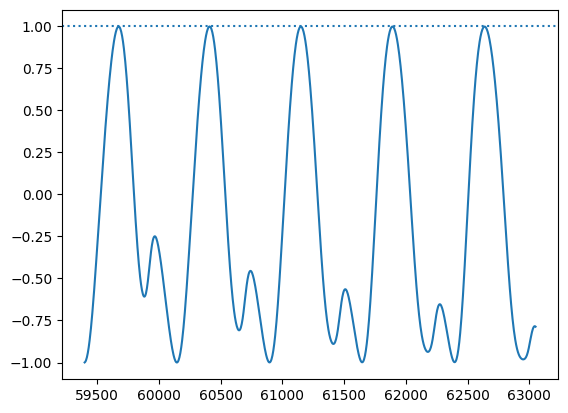

In [13]:
pp.plot(ts, get_cos(ts, 'mars', 'saturn', orbint))
pp.axhline(1,ls=':')

In [14]:
def get_max(tinit):
    minimum = scipy.optimize.minimize(lambda t: -get_cos(t, 'mars', 'saturn', orbint),
                                      x0=tinit, bounds=[(t0.mjd, t1.mjd)])
    
    return int(minimum.x)

In [15]:
print([get_max(t) for t in range(59500, 63000, 50)])

/tmp/ipykernel_57164/3410326645.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(minimum.x)


[59674, 59674, 59674, 59674, 59674, 59674, 59674, 59674, 59967, 59967, 59967, 59674, 59967, 60410, 60410, 60410, 61892, 60410, 60410, 60410, 60410, 60410, 60410, 60649, 62638, 60741, 60741, 60741, 61150, 61150, 61150, 61150, 61150, 61150, 61150, 61150, 61150, 59967, 61150, 61510, 62638, 61510, 61510, 61892, 61892, 61892, 61892, 61892, 61892, 61892, 61892, 61892, 60742, 61892, 62275, 62638, 62275, 62275, 62638, 62638, 62638, 62638, 62638, 62638, 62638, 62638, 62638, 62638, 62638, 62949]


In [16]:
times = list(set(get_max(t) for t in range(59500, 63000, 50)))

/tmp/ipykernel_57164/3410326645.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(minimum.x)


In [17]:
times

[60410,
 62275,
 61892,
 60741,
 61510,
 60742,
 62949,
 60649,
 62638,
 59674,
 61150,
 59967]

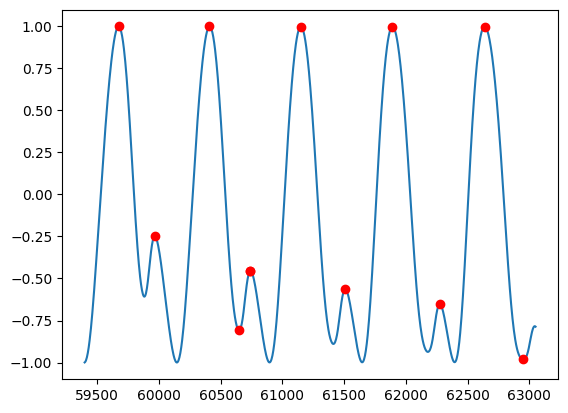

In [18]:
pp.plot(ts, get_cos(ts, 'mars', 'saturn', orbint))
pp.plot(list(times),
        get_cos(list(times), 'mars', 'saturn', orbint), 'ro')

In [19]:
conjunctions = [t for t in times if get_cos(t, 'mars', 'saturn', orbint) > 0.99]

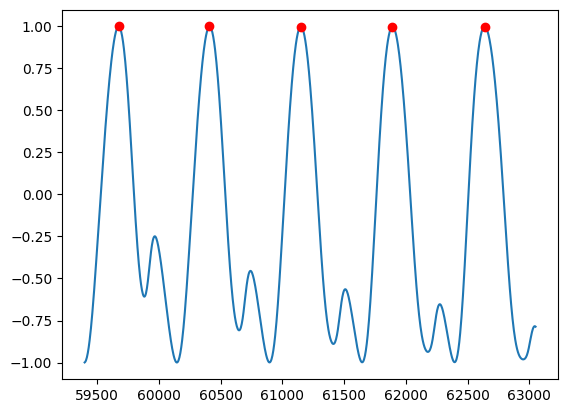

In [22]:
pp.plot(ts, get_cos(ts, 'mars', 'saturn', orbint))
pp.plot(conjunctions, get_cos(list(conjunctions), 'mars', 'saturn', orbint), 'ro')

In [23]:
[astropy.time.Time(t, format='mjd').iso for t in conjunctions]

['2024-04-10 00:00:00.000',
 '2028-05-01 00:00:00.000',
 '2030-05-17 00:00:00.000',
 '2022-04-05 00:00:00.000',
 '2026-04-20 00:00:00.000']